# Workflow For Designing Closed Loop Systems

PID Feedback Architecture

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

State Feedback Architecture (without disturbance and noise)

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_24-Testbed-for-Full-State-Feedback/Full-State-Feedback.png?raw=true"
alt="Markdown Monster icon"
width=500pt
style="float: left; margin-right: 10px;" />

This notebook develops closed loop systems for SBML models to elucidate the underlying workflow.

# Issues

1. Filter for full state feedback

# Preliminaries

## Imports

In [1]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import control
import controlSBML as ctl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

     |████████████████████████████████| 398 kB 32.5 MB/s 
     |████████████████████████████████| 121 kB 31.4 MB/s 
     |████████████████████████████████| 54.8 MB 137 kB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 2.6 MB 47.0 MB/s 
     |████████████████████████████████| 6.8 MB 32.2 MB/s 
     |████████████████████████████████| 2.1 MB 31.8 MB/s 
     |████████████████████████████████| 5.0 MB 51.4 MB/s 
     |████████████████████████████████| 5.6 MB 51.5 MB/s 
     |████████████████████████████████| 3.2 MB 46.7 MB/s 
     |████████████████████████████████| 3.3 MB 45.8 MB/s 
     |████████████████████████████████| 36.7 MB 1.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |█████████████████████

## Constants

In [2]:
BIOMD823 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000823.2?filename=Varusai2018.xml"
BIOMD206 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"

# Antimony Model

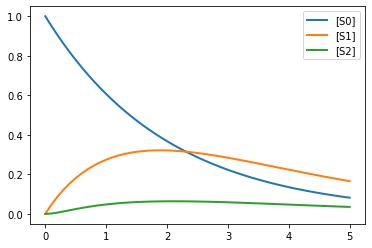

In [3]:
ANT_MODEL = """
S0 -> S1; k0*S0
S1 -> S2; k1*S1
S2 -> S1; k2*S2
S2 -> ; k3*S2

S0 = 1
S1 = 0
S2 = 0
S3 = 0
k0 = 0.5
k1 = 1
k2 = 2
k3 = 3
"""
rr = te.loada(ANT_MODEL)
rr["S0"] = 1
rr.simulate()
rr.plot()

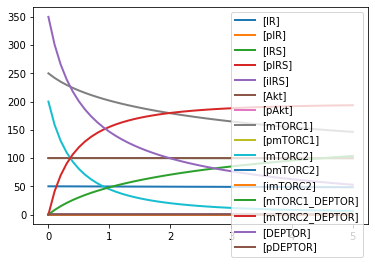

In [4]:
ctlsb = ctl.ControlSBML(BIOMD823)
#ctlsb.set({"S0": 1})
rr = ctlsb.roadrunner
#rr["S0"] = 1
rr.simulate()
rr.plot()

# Model of Glycoytic Oscillations (BioModels 206)

**Reactions in Glycolytic Oscillations**

``at`` is ``ATP``; ``s5`` is ``pyruvate``.

    v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
    v2: s2 -> 2 s3; compartment_*k2*s2;
    v3: s3 + na -> s4 + at_;compartment_*((k31*k32*s3*na*(atot - at_) 
        - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
    v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
    v5: s5 -> s6; compartment_*k5*s5;
    v7: at_ -> ; compartment_*k7*at_;
    v8: s3 -> na; compartment_*k8*s3*(ntot - na);
    v9: s6o -> ; compartment_*k9*s6o;
    v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
    v6: s6 -> na; compartment_*k6*s6*(ntot - na);
    v0:  -> s1; compartment_*k0;

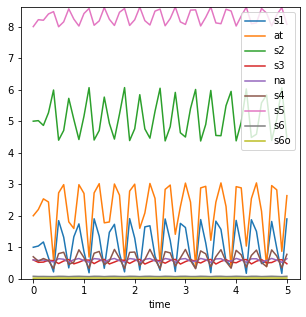

In [5]:
ctlsb = ctl.ControlSBML(BIOMD206)
ctlsb.plotTrueModel(figsize=(5,5))

# Analysis Workflow

## Step 1: Create Analysis Objects

In [6]:
ctlsb = ctl.ControlSBML(ANT_MODEL, input_names=["S0"], output_names=["S1", "S2"])
siso = ctl.SISOClosedLoopSystem(ctlsb)

## Step 2: Evaluate Controllability

In [7]:
dct = siso.evaluateControllability(range(5))
for time in dct.keys():
    print("\n%d" % time)
    print(dct[time])


0
          S1        S2
S0  0.833333  0.166667

1
          S1        S2
S0  0.833333  0.166667

2
          S1        S2
S0  0.833333  0.166667

3
          S1        S2
S0  0.833333  0.166667

4
          S1        S2
S0  0.833333  0.166667


## Step 3A: Evaluate PID Closed Loop System

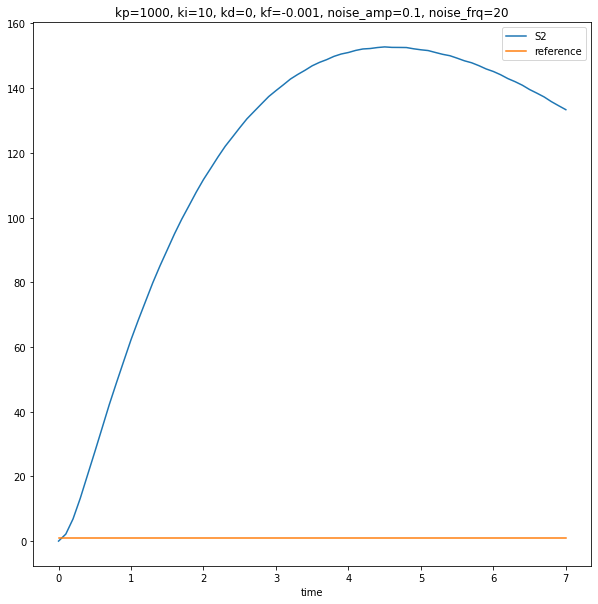

OK!


In [8]:
def evaluateClosedLoopSystem(ctlsb, is_plot=True, cl_opts={}, plt_opts={}, sim_opts={},
                method=ctl.SISOClosedLoopSystem.makePIDClosedLoopSystem):
    """
    Evaluate a PID controller by plotting step response.
    
    Parameters
    ----------
    cl_opts: dict
        Options for the closed loop system. See parameters for SISOClosedLoopSystem.makePIDClosedLoopSystem
    plt_opts: dict
        Options for plottling. See ctl.plotOneTs
    sim_opts: dict
        Options for simulation
            start_time: float
            end_time: float
            points_per_time: int
    """
    siso = ctl.SISOClosedLoopSystem(ctlsb)
    # Handle the method to call
    extracted_method = method.__qualname__.split(".")[1]
    stmt = "siso.%s(**cl_opts)" % extracted_method
    eval(stmt)
    ts = siso.makeStepResponse(**sim_opts)
    titles = ["%s=%s" % (k, v) for k, v in cl_opts.items()]
    title = ", ".join(titles)
    if is_plot:
        ctl.plotOneTS(ts, title=title, **plt_opts)
    return ts

# Tests
cl_opts=dict(kp=1000, ki=10, kd=0, kf=-0.001, noise_amp=0.1, noise_frq=20)
sim_opts = dict(end_time=7)
ctlsb = ctl.ControlSBML(ANT_MODEL, input_names=["S0"], output_names=["S1", "S2"])
ts = evaluateClosedLoopSystem(ctlsb, cl_opts=cl_opts, sim_opts=sim_opts, 
                              is_plot=True)
assert("Timeseries" in str(type(ts)))
print("OK!")

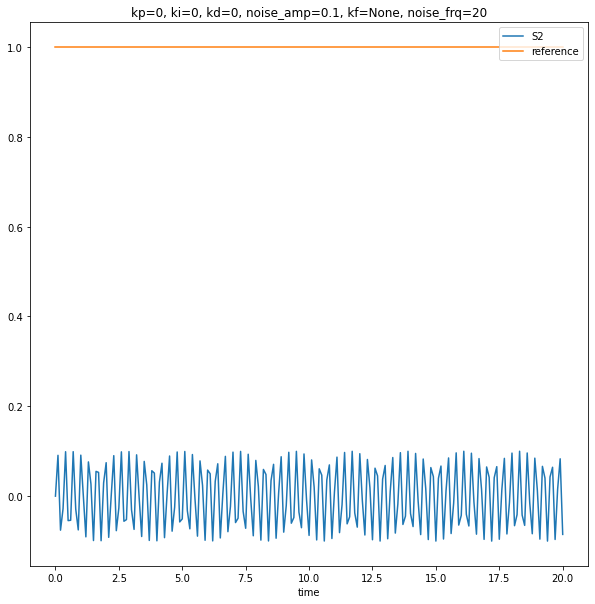

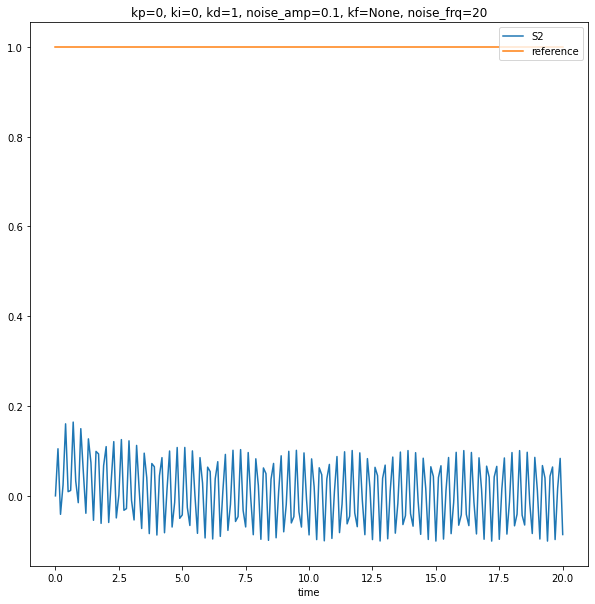

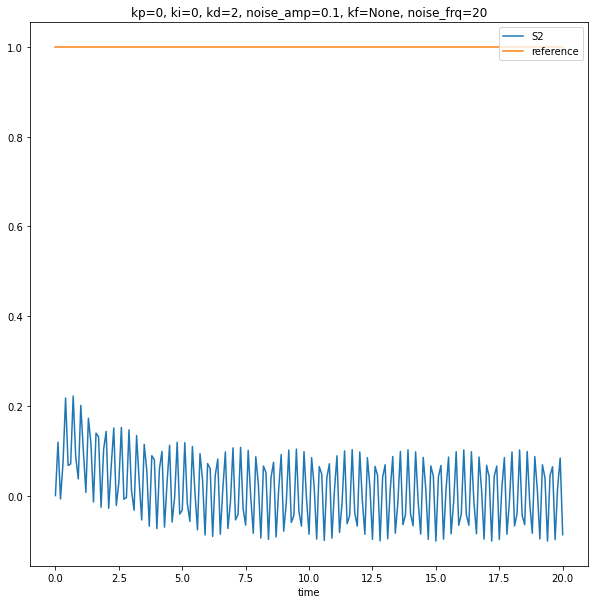

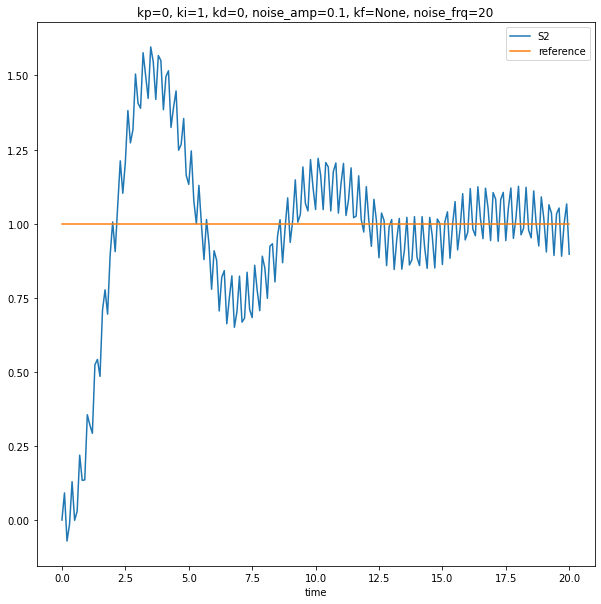

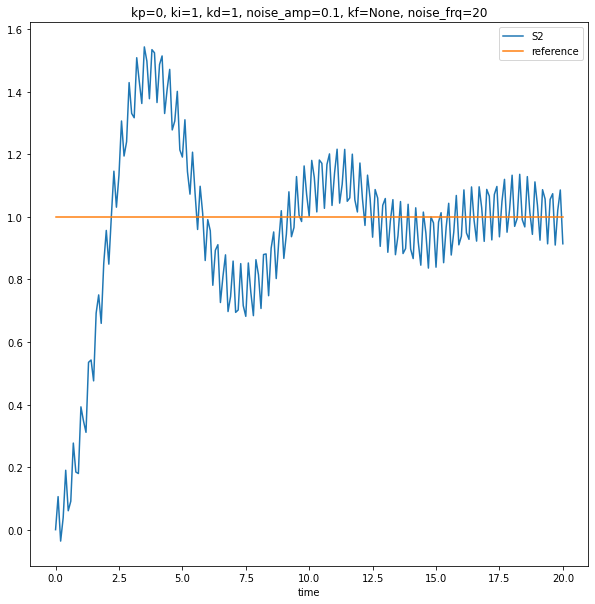

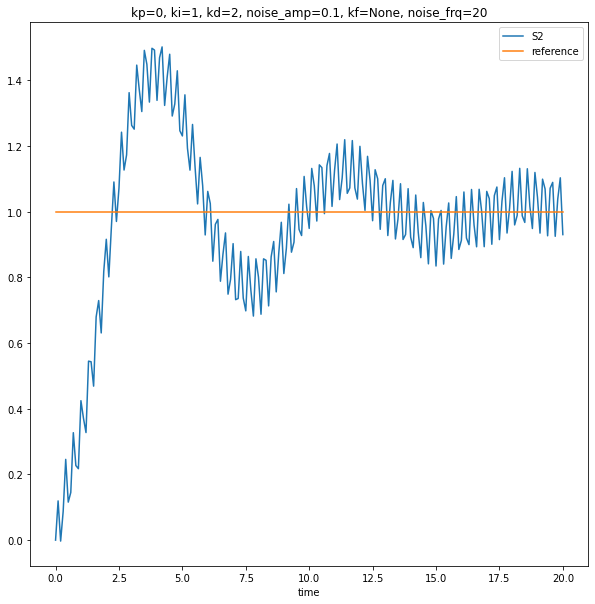

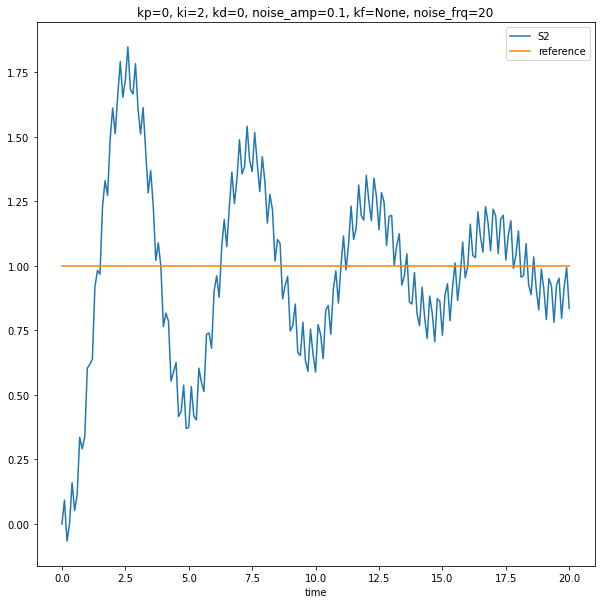

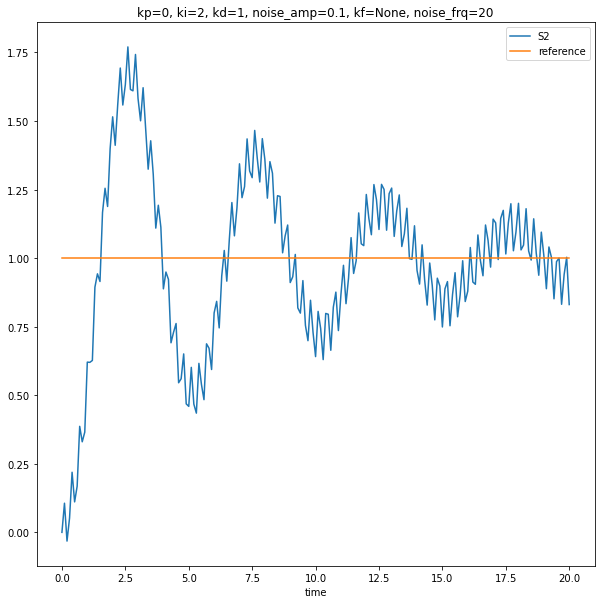

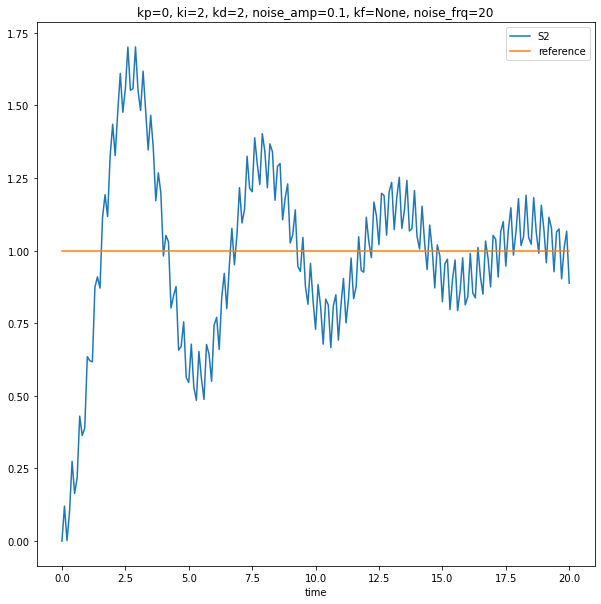

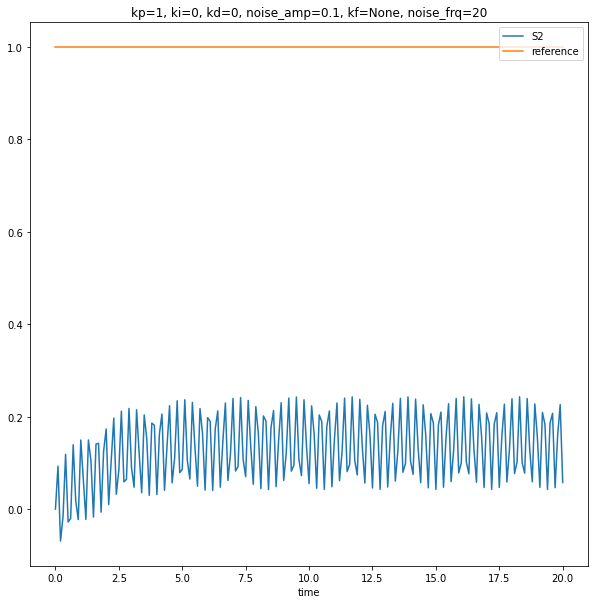

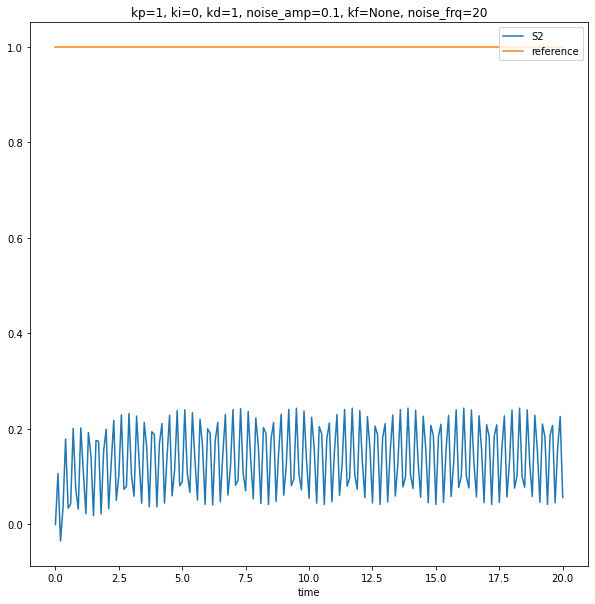

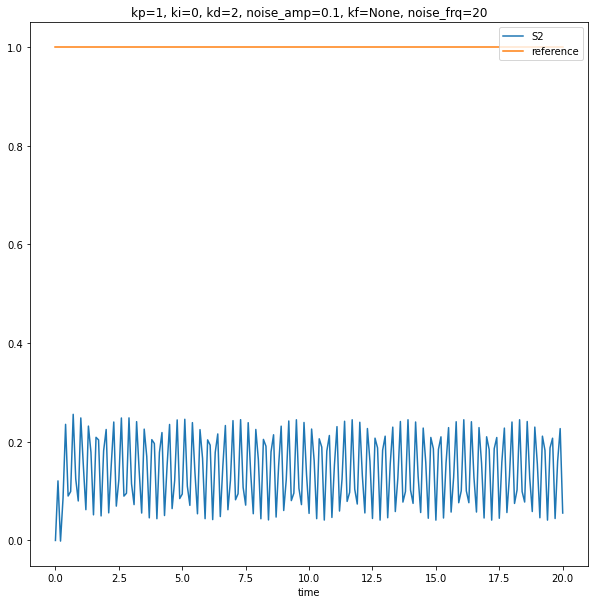

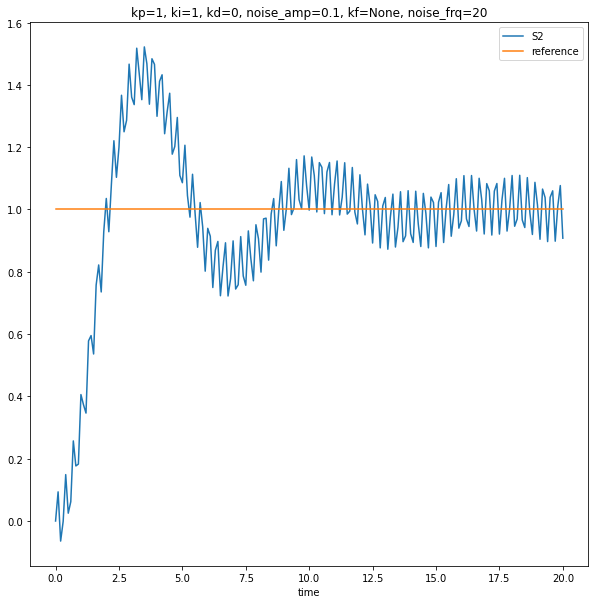

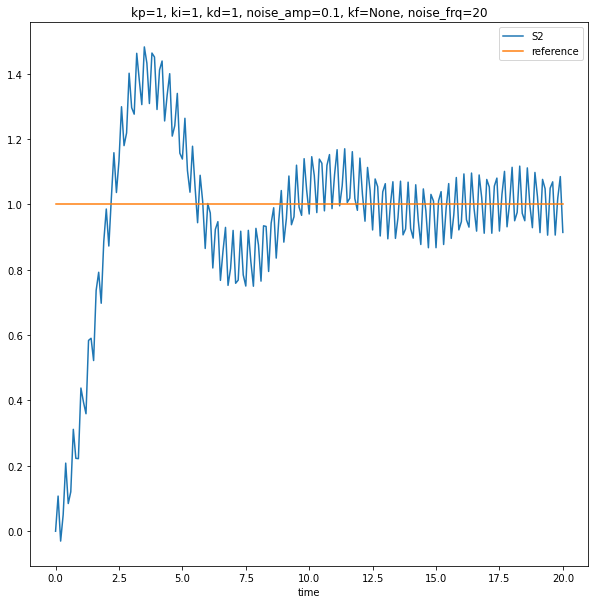

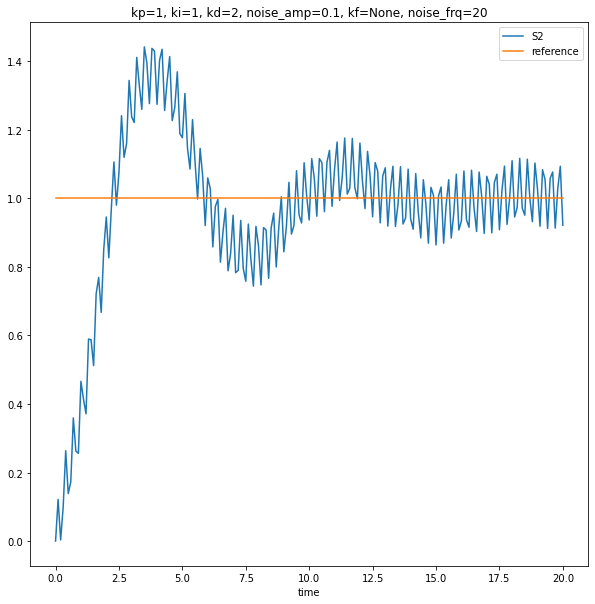

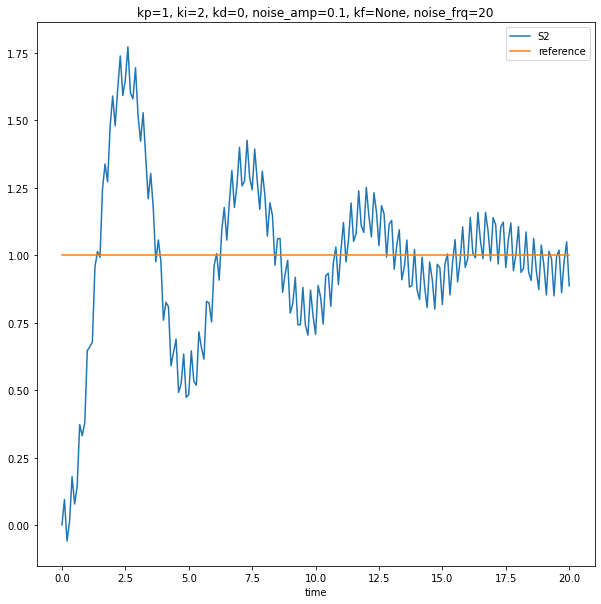

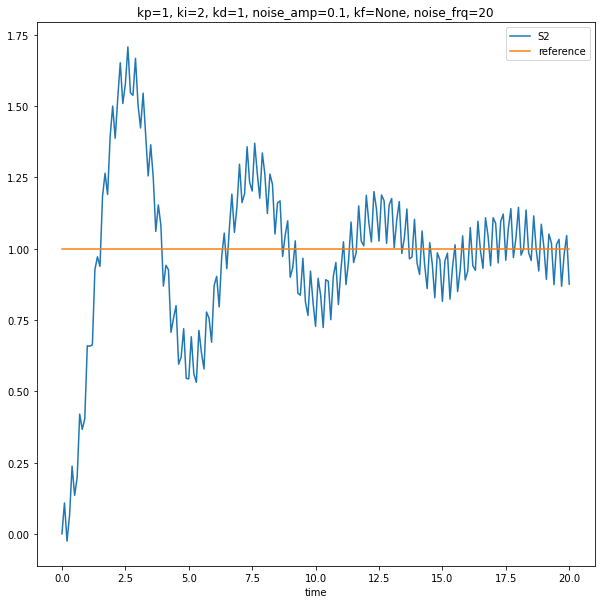

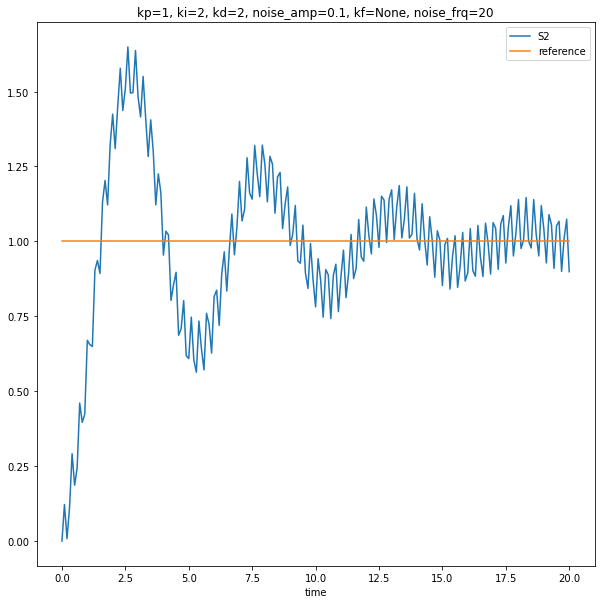

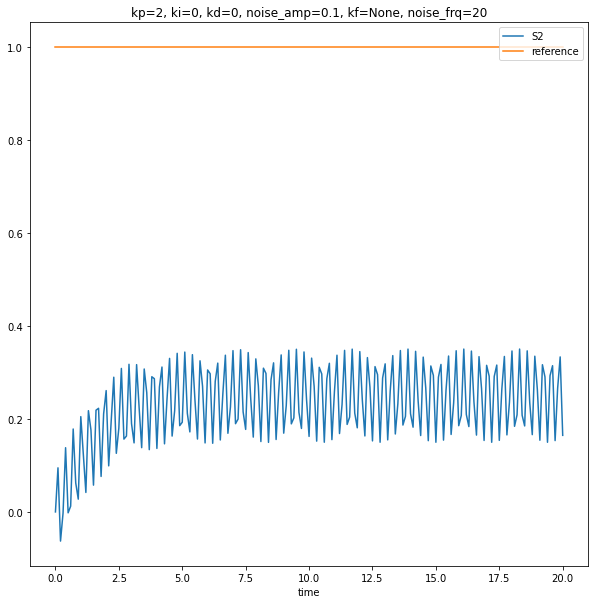

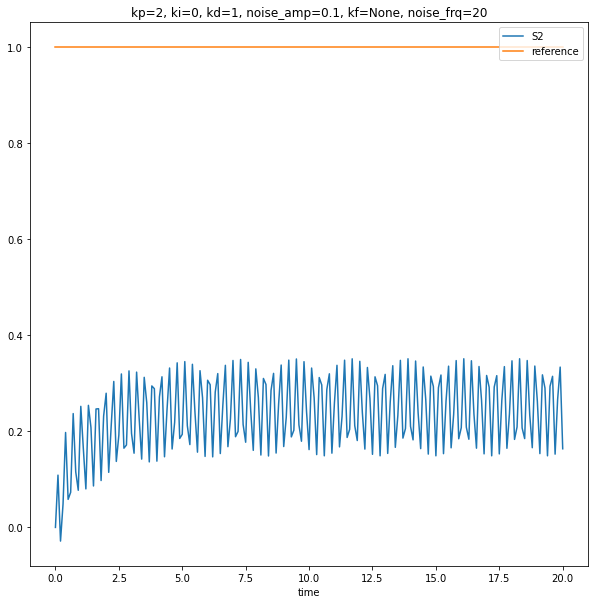

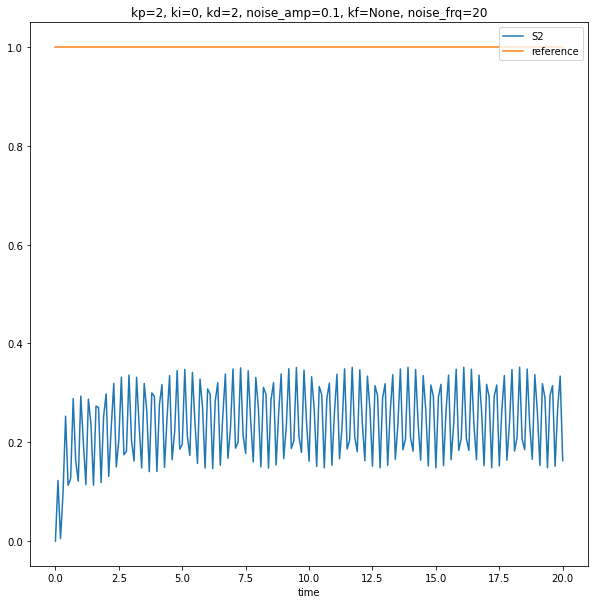

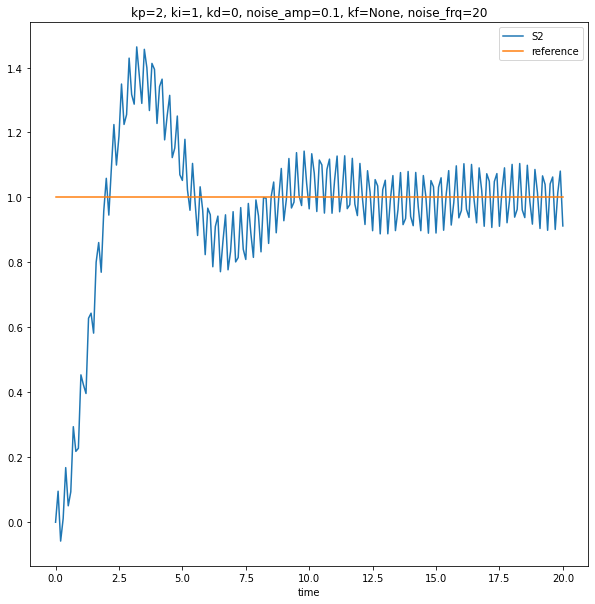

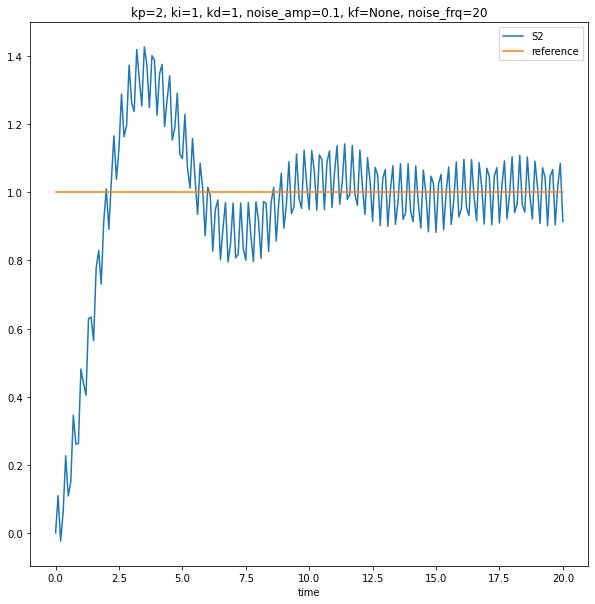

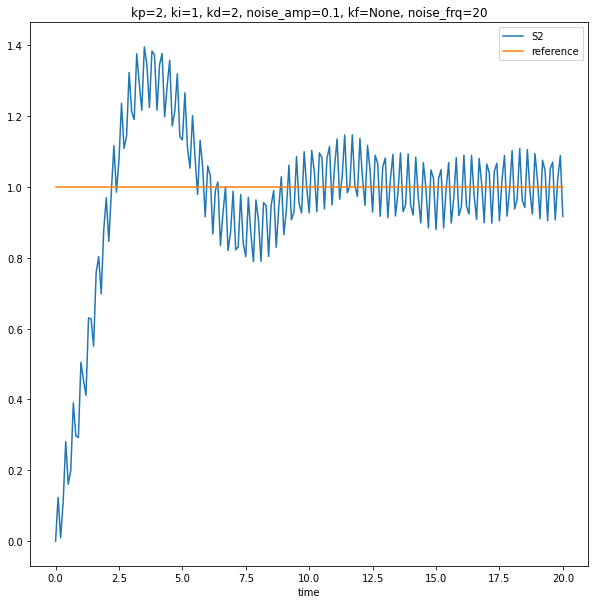

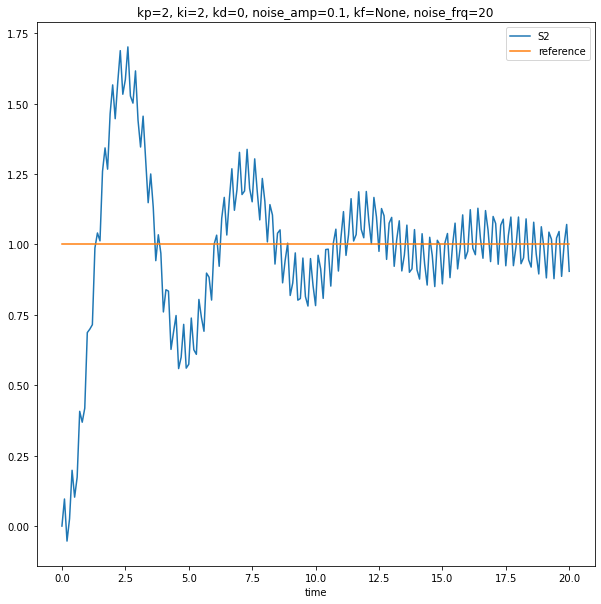

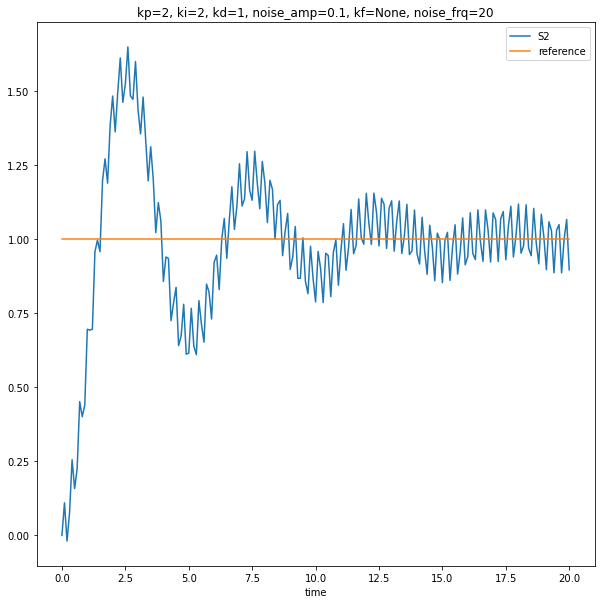

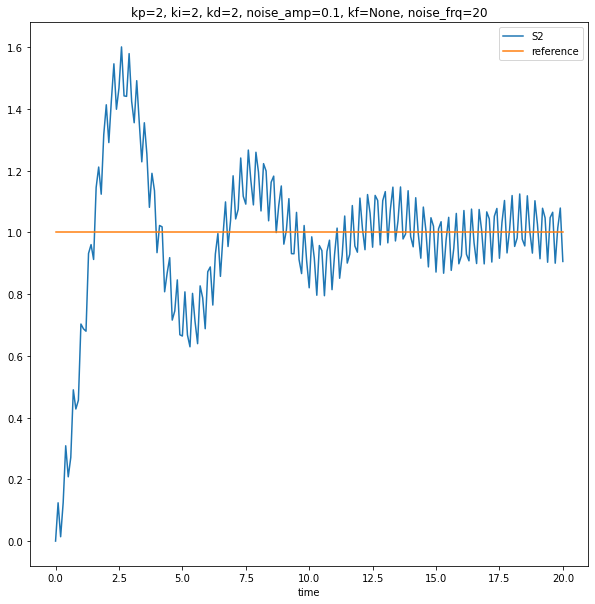

In [9]:
ctlsb = ctl.ControlSBML(ANT_MODEL, input_names=["S0"], output_names=["S1", "S2"])
for kp in range(0, 3):
    for ki in range(0, 3):
        for kd in range(0, 3):
            cl_opts = dict(kp=kp, ki=ki, kd=kd, noise_amp=0.1, kf=None, noise_frq=20)
            sim_opts = dict(end_time=20)
            evaluateClosedLoopSystem(ctlsb, cl_opts=cl_opts, sim_opts=sim_opts)

## Step 3B: Evaluate Full State Closed Loop System

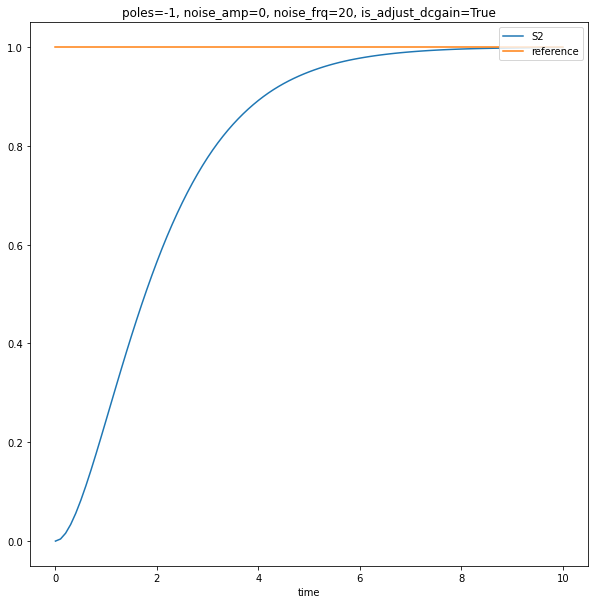

In [10]:
cl_opts=dict(poles=-1, noise_amp=0, noise_frq=20, is_adjust_dcgain=True)
method = ctl.SISOClosedLoopSystem.makeFullStateClosedLoopSystem
sim_opts = dict(end_time=10)
ts = evaluateClosedLoopSystem(ctlsb, cl_opts=cl_opts, sim_opts=sim_opts, method=method)

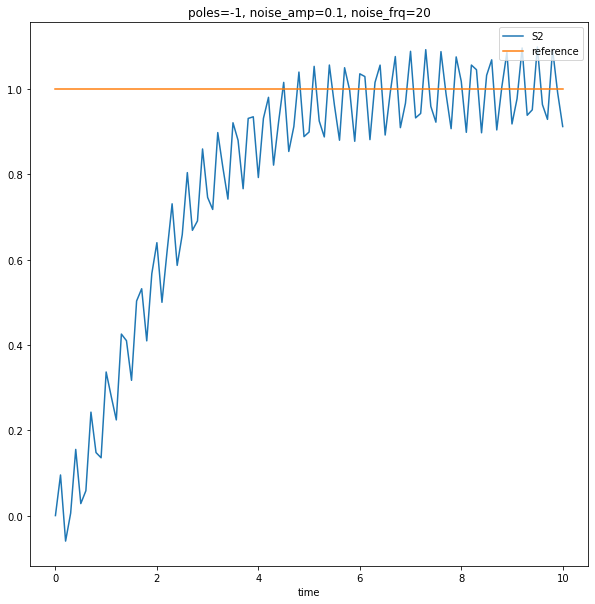

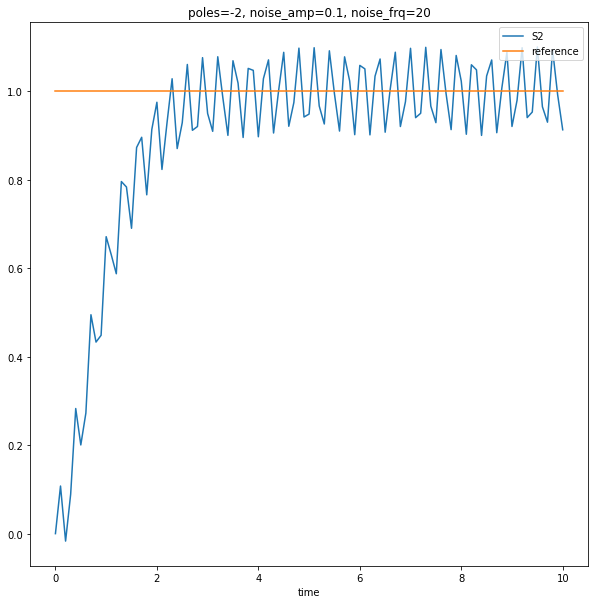

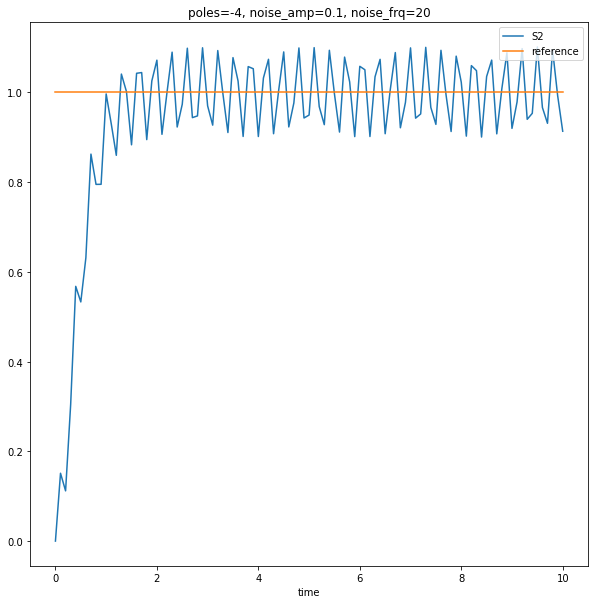

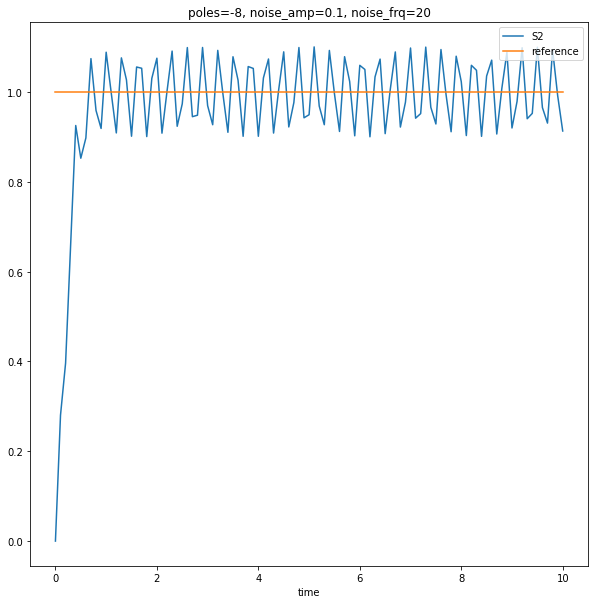

In [11]:
sim_opts = dict(end_time=10)
for pole in [-1, -2, -4, -8]:
    cl_opts=dict(poles=pole, noise_amp=0.1, noise_frq=20)
    evaluateClosedLoopSystem(ctlsb, cl_opts=cl_opts, sim_opts=sim_opts, method=method)

# SBML Models


## Objects

In [12]:
CTLSB823 = ctl.ControlSBML(BIOMD823, input_names=["pAkt"], output_names=["DEPTOR"])
SISO823 = ctl.SISOClosedLoopSystem(CTLSB823)

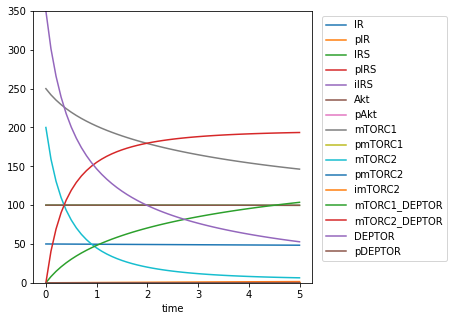

In [13]:
CTLSB823.plotTrueModel(figsize=(5,5), end_time=5, legend_crd=(1.5, 1))

## Controllability

In [14]:
dct = SISO823.evaluateControllability([0, 1, 2.5], input_names=["Akt", "pAkt", "pIRS", "IR"], output_names=["pDEPTOR", "DEPTOR"])
for time in dct.keys():
    print("\n%d" % time)
    print(dct[time])


0
      pDEPTOR  DEPTOR
Akt       NaN     NaN
pAkt      NaN     NaN
pIRS      NaN     NaN
IR        NaN     NaN

1
      pDEPTOR  DEPTOR
Akt       NaN     NaN
pAkt      NaN     NaN
pIRS      NaN     NaN
IR        NaN     NaN

2
      pDEPTOR  DEPTOR
Akt       NaN     NaN
pAkt      NaN     NaN
pIRS      NaN     NaN
IR        NaN     NaN


## Closed Loop Design

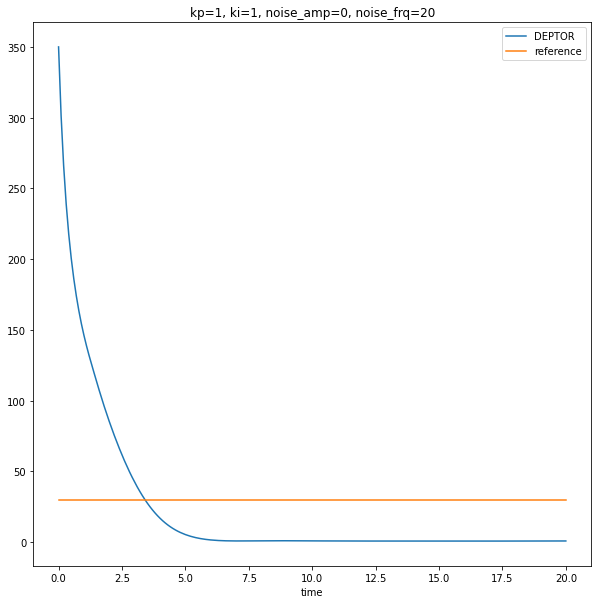

In [15]:
cl_opts=dict(kp=1, ki=1, noise_amp=0, noise_frq=20)
method = ctl.SISOClosedLoopSystem.makePIDClosedLoopSystem
sim_opts = dict(end_time=20, step_size=30)
ts = evaluateClosedLoopSystem(CTLSB823, cl_opts=cl_opts, sim_opts=sim_opts, method=method)

# Previously Untried SBML Model

In [16]:
 BIOMD1015 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001015.2?filename=Jarrah2014.xml"
 CTLSB1015 = ctl.ControlSBML(BIOMD1015)
 #SISO1015 = ctl.SISOClosedLoopSystem(CTLSB1015)
 print(CTLSB1015.antimony)

// Created by libAntimony v2.13.1
function Rate_Law_for_reaction_4(bm, k3, D, M)
  bm + k3*D*M;
end

Rate_Law_for_reaction_4 is "Rate Law for reaction_4"

function Rate_Law_for_reaction(bH, k1, D, M)
  bH + k1*D*M;
end

Rate_Law_for_reaction is "Rate Law for reaction"

function Rate_Law_for_reaction_6(k5, C, N, alpha)
  k5*C*N + alpha*N;
end

Rate_Law_for_reaction_6 is "Rate Law for reaction_6"


model *Jarrah2014___mathematical_model_of_the_immune_response_in_muscle_degeneration_and_subsequent_regeneration_in_Duchenne_muscular_dystrophy_in_mdx_mice()

  // Compartments and Species:
  compartment compartment_;
  species H in compartment_, D in compartment_, M in compartment_, C in compartment_;
  species N in compartment_, R in compartment_;

  // Assignment Rules:
  bH := dH*H0;
  bC := dC*C0;
  bM := dM*M0;
  alpha := (h/((time + 1e-11)*sigma*(2*pi)^0.5))*exp(-(ln(time + 1e-11) - m)^2/(2*sigma^2));

  // Reactions:
  reaction_:  => H; compartment_*Rate_Law_for_reaction(bH, k1, D, M);

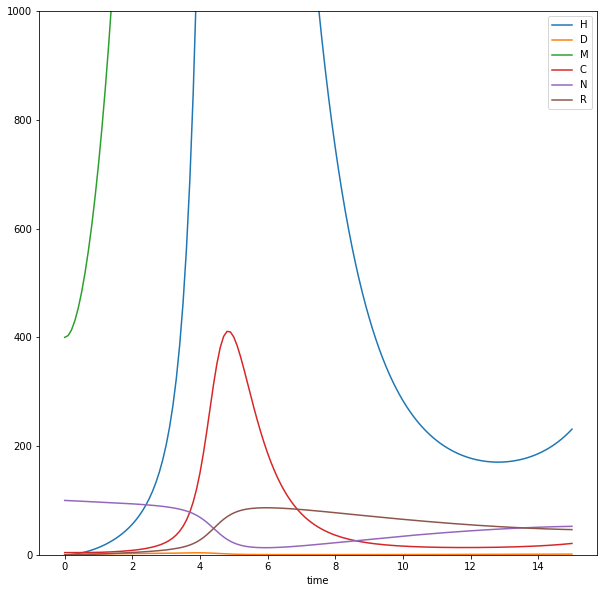

In [17]:
CTLSB1015.plotTrueModel(ylim=[0, 1000], end_time=15)

In [18]:
# Calculating dcgain if there are nans or infs
SISO1015 = ctl.SISOClosedLoopSystem(CTLSB1015)
ss = CTLSB1015.makeStateSpace()
total = np.sum(ss.A.flatten())
if np.isnan(total):
    tf = control.TransferFunction([0], [1])
else:
    tf = control.ss2tf(ss)
tf.dcgain()

0.0

In [19]:
# An empty dataframe means that dcgain could not be calculated
SISO1015.evaluateControllability([0, 1])

{0: Empty DataFrame
 Columns: []
 Index: [], 1: Empty DataFrame
 Columns: []
 Index: []}

if ControlSBML is unable to construct transfer function, try using scipy. Look at https://dsp.stackexchange.com/questions/70624/how-to-model-transfer-functions-using-python-without-using-higher-level-package

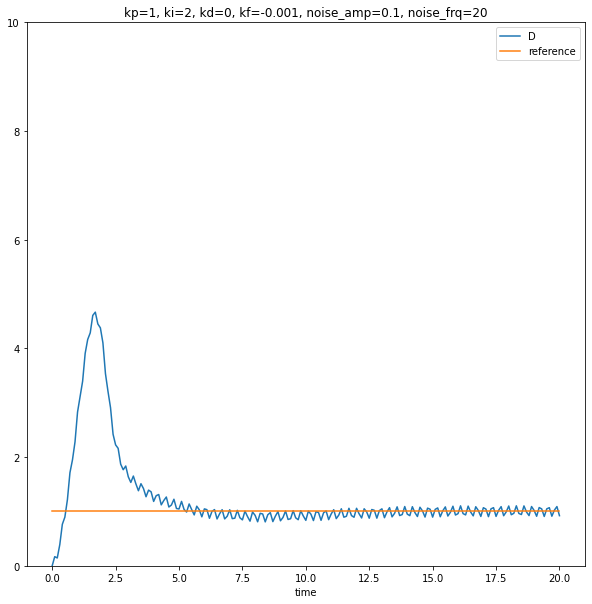

In [20]:
cl_opts=dict(kp=1, ki=2, kd=0, kf=-0.001, noise_amp=0.1, noise_frq=20)
sim_opts = dict(end_time=20)
ctlsb = ctl.ControlSBML(BIOMD1015, input_names=["C"], output_names=["D"])
ts = evaluateClosedLoopSystem(ctlsb, cl_opts=cl_opts, sim_opts=sim_opts, plt_opts={"ylim": [0, 10]})